In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pymongo
import os, sys
from IPython import display
import matplotlib.patches as mpatches
from sklearn import manifold, datasets
import numpy as np
import pandas as pd
import plotly.plotly as py
import plotly.tools as tls
from IPython.core.display import display as dplay, HTML
dplay(HTML("<style>.container { width:100% !important; }</style>"))
root_dir = "/home/cs/Documents/pymarl/src"
sys.path = ['/home/cs/Documents/pymarl/src'] + sys.path

In [2]:
from config import mongodb

In [3]:
from config.mongodb import REGISTRY as mongo_REGISTRY
def get_mongo_db_client(conf_name, maxSevSelDelay=5000):    
    mongo_conf = mongo_REGISTRY[conf_name](None, None)
    db_url = mongo_conf["db_url"]
    db_name = mongo_conf["db_name"]
    client = pymongo.MongoClient(db_url, ssl=True, serverSelectionTimeoutMS=maxSevSelDelay)
    return client, client[db_name]

In [4]:
class MongoCentral():
    
    def __init__(self, *args, **kwargs):
        self.conf_names = kwargs["conf_names"]
        self.db = {}
        self._connect(self.conf_names)
        
    def _connect(self, conf_names):
        self.clients = {}
        for _name in conf_names:
            self.clients[_name], self.db[_name] = get_mongo_db_client(_name)
            
    def get_exp_names(self):
        #print("Loading keys...")
        names = []
        for key, db in self.db.items():
            query = db["runs"].distinct("config.name") # .find({"config":None})
            names.extend(query)
            print("Done Loading...")
        return names
    
    def get_tag_names(self, tag, bundle=True):
        import re
        names = []
        for key, db in self.db.items():            
            query = db.runs.find({"config.name":{'$regex':r'^{}\_\_(.*)'.format(tag)}}, {"config.name":1}) # .find({"config":None})
            names.extend([_q["config"]["name"] for _q in query])
            print("Done Loading...")
            
        if bundle: # bundle by experiment name
            bundle_dic = {}
            for name in names:
                #tag, exp_name_time_stamp, repeat = name.split("__")
                exp_name_time_stamp = "__".join(name.split("__")[1:-1])
                exp_name = "_".join(exp_name_time_stamp.split("_")[:-1])
                if exp_name not in bundle_dic:
                    bundle_dic[exp_name] = []
                bundle_dic[exp_name].append(name) 
            return bundle_dic
        return names

    def get_name_prop(self, name, prop):
        res = []
        for key, db in self.db.items():
            query = db.runs.find({"config.name":name}, {prop:1})
            for _q in query:
                res.append(_q)
        return res

In [5]:
mongo_central = MongoCentral(conf_names=["gandalf_pymarl"])

In [6]:
import pprint
comajakob = mongo_central.get_tag_names("COMAJAKOB")
flok6_3m = mongo_central.get_tag_names("FLOK6_3m")
flok6_5m = mongo_central.get_tag_names("FLOK6_5m")
flok6_4a6x6pp = mongo_central.get_tag_names("FLOK6_4a6x6pp")
cjak2 = mongo_central.get_tag_names("CJAK2")
pprint.pprint(comajakob)
pprint.pprint(flok6_3m)
pprint.pprint(flok6_5m)
pprint.pprint(flok6_4a6x6pp)

Done Loading...
Done Loading...
Done Loading...
Done Loading...
Done Loading...
{'coma_jakob_sc2_3m': ['COMAJAKOB__coma_jakob_sc2_3m_17/05/18-04:17:42__repeat1',
                       'COMAJAKOB__coma_jakob_sc2_3m_17/05/18-04:17:42__repeat2',
                       'COMAJAKOB__coma_jakob_sc2_3m_17/05/18-04:17:42__repeat3',
                       'COMAJAKOB__coma_jakob_sc2_3m_17/05/18-04:17:42__repeat4',
                       'COMAJAKOB__coma_jakob_sc2_3m_17/05/18-04:17:42__repeat5',
                       'COMAJAKOB__coma_jakob_sc2_3m_17/05/18-04:17:42__repeat6',
                       'COMAJAKOB__coma_jakob_sc2_3m_17/05/18-04:17:42__repeat7',
                       'COMAJAKOB__coma_jakob_sc2_3m_17/05/18-04:17:42__repeat8',
                       'COMAJAKOB__coma_jakob_sc2_3m_17/05/18-04:17:42__repeat9',
                       'COMAJAKOB__coma_jakob_sc2_3m_17/05/18-04:17:42__repeat10',
                       'COMAJAKOB__coma_jakob_sc2_3m_17/05/18-04:17:42__repeat11',
                

In [7]:
def plot_bundle(bundle, 
                mongo_central, 
                prop, 
                mode = "", 
                ax=None, 
                nan_ax=None, 
                std_ax=None,
                scatter_ax=None,
                allplots_ax=None,
                color=("#6255ed", "#cccbfc"), 
                x_range=None): # mode: individual, all
    
    if mode in ["individual"]:
        # make separate plot for each key, showing all subkeys
        df_dict={}
        for _exp, _names in bundle.items():
            episode_rewards_test = []
            t_env_test = []
            dfs = []
            for _i, _name in enumerate(_names):
                ret = mongo_central.get_name_prop(_name, "info.{}".format(prop))  
                test_mode = prop.split(" ")[-1] == "test"
                if test_mode:
                    ret2 = mongo_central.get_name_prop(_name, "info.T env test")                    
                else:
                    ret2 = mongo_central.get_name_prop(_name, "info.T env")
                try:
                    if ret[0]["info"] != {}:
                        episode_rewards_test.append(ret[0]["info"][prop])
                        if test_mode:
                            t_env_test.append(ret2[0]["info"]["T env test"])
                        else:
                            t_env_test.append(ret2[0]["info"]["T env"])
                        #print(t_env_test)
                        #print(episode_rewards_test)
                        min_len = min(len(t_env_test[-1]), len(episode_rewards_test[-1]))
                        df2 = pd.DataFrame(data=episode_rewards_test[-1])
                        # df2.plot(figsize=(20, 10))
                        df  = pd.DataFrame(data=episode_rewards_test[-1][:min_len], 
                                           columns=["{}{}".format(_exp, _i)], 
                                           index=t_env_test[-1][:min_len])
                        # df.plot(figsize=(20, 10))
                        dfs.append(df)
                    else:
                        #episode_rewards_test.append([])
                        #t_env_test.append([])                    
                        pass
                except:
                    continue
                #print(episode_rewards_test)
                #print(t_env_test)
            total_df = pd.concat(dfs)
            total_df.index = total_df.index.astype(int)
            total_df = total_df.sort_index()
            total_df = total_df.groupby(total_df.index).mean()
            # total_df.plot(figsize=(20, 10))
            if x_range is not None:
                mask = (total_df.index > x_range[0]) & (total_df.index <= x_range[1])
                total_df = total_df.iloc[mask] #iloc[ x_range[0]:x_range[1]]
            
            nan_df = total_df.fillna(method='bfill').isna().sum(axis=1)*(-1) + len(total_df.columns) #isnull().sum(axis=1)    
            #print(nan_df)
            #return
            
            try:            
                # interpol_df = total_df.interpolate(method="nearest")
                total_df = total_df.interpolate(method="nearest")
                #pl = interpol_df.plot(title="Experiment: {}".format(_exp),
                #  figsize=(20, 10))
                df_mean = interpol_df.mean(axis=1, skipna=True)
                # df_std = interpol_df.std(axis=1, skipna=True)
                df_std = interpol_df.var(axis=1, skipna=True) / nan_df
                df_dict[_name] = interpol_df
            except Exception as e:
                total_df = total_df.fillna(method='bfill')
                #pl = total_df.plot(title="Experiment: {}".format(_exp),
                #  figsize=(20, 10))
                df_mean = total_df.mean(axis=1, skipna=True)
                #df_std = total_df.std(axis=1, skipna=True)
                df_std = total_df.var(axis=1, skipna=True) / nan_df
                df_dict[_name] = total_df
            
            total_df_ordered = total_df.reindex_axis(total_df.mean().sort_values().index, axis=1)
            best_run, worst_run = total_df_ordered.iloc[:, 0], total_df_ordered.iloc[:, -1]
            # print(best_run)
            
            #ax.plot(best_run, color=color[1])
            #ax.plot(worst_run, color=color[1])
            
            # plot_std_tube(pl, df_mean, df_std)
            if ax is None:
                pl2 = df_mean.plot(title="Experiment: {}".format(_exp),
                                   figsize=(20, 10))
            else:
                # print("HELLO")
                pl2 = df_mean.plot(ax=ax, color=color[0])
                #plnan = nan_df.plot(title="Experiment: {}".format(_exp),
                #                   figsize=(20, 10), ax=nan_ax, color=color[0])
                #nan_ax.fill_between(nan_df.index, 0,  
                #                    nan_df, color=color[1], alpha=0.5)
                std_ax.fill_between(df_std.index, 0,  
                                    df_std, color=color[1], alpha=0.5)
                # print(total_df)
            best_run.plot(ax=pl2, color=color[1], alpha=0.9, linestyle="--")
            # best_run.plot(ax=allplots_ax, color=color[1], alpha=0.9, linestyle="--")
            total_df.plot(ax=allplots_ax, color=color[0], linestyle="--", alpha=0.6)
            worst_run.plot(ax=pl2, color=color[1], alpha=0.9, linestyle="--")
            
            tsne = manifold.TSNE(n_components=2, init='random',
                                 random_state=0, perplexity=10)
            X = total_df.values.transpose()
            X[X!=X] = 0.0
            # for x in X:
            #    print(x)
            Y = tsne.fit_transform(X)
            red = 0
            scatter_ax.scatter(Y[:, 0], Y[:, 1], c=color[0])
            # print(Y)
            #plot_std_tube(pl2, df_mean, df_std, color=color)
            
        return nan_df
            #break
            
    elif mode in ["all"]: 
        # plot all keys on same plot, averaging over subkeys

        pass

def plot_std_tube(pl, df_mean, df_std, color): #color="#EFF9FC"):
    pass
    #std = df_std.std(axis=1, skipna=True)
    #mn = df_mean.mean(axis=1, skipna=True)
    # df_mean.plot(ax=pl, color=color[0], alpha=0.7) # style='y^-')
    #pl.fill_between(df_mean.index, df_mean - df_std,  
    #             df_mean + df_std, color=color[1], alpha=0.7)
    
def plot_bundles(bundles, mongo_central, props, labels, x_range=None, fig_title=""):
    colors = [("#6255ed", "#cccbfc"), ("#ff5d5d", "#ffcccc"), ("#038103", "#cce5cc"), ("#ff14ff", "#ff14ff")]
    # fig, ax = plt.subplots(1,1)
    fig = plt.figure(figsize=(40,20))
    gs1 = gridspec.GridSpec(nrows=5*len(bundles), ncols=5, left=0.00, right=0.7, wspace=0.01)
    ax1 = fig.add_subplot(gs1[:-1, :])
    # ax_std = fig.add_subplot(gs1[-2, :])
    ax_nan = fig.add_subplot(gs1[-1, :])
    ax_scatter = fig.add_subplot(gs1[-10:-6, 2:3])
    #ax_allplots = [fig.add_subplot(gs1[-10:-6, 3:5]) for _j, _ in enumerate(bundles)]
    ax_allplots = [fig.add_subplot(gs1[5*len(bundles)//2-2*len(bundles)//2+2*_j:5*len(bundles)//2-2*len(bundles)//2+2*_j+2, 3:5]) for _j, _ in enumerate(bundles)]
    # ax1 = fig.add_subplot(gs1[-2, :])
    # ax2 = []
    # for _i, _ in enumerate(bundles):
    #    ax2.append(fig.add_subplot(gs1[-len(bundles)+_i, :]))
    patches = []
    nans = []
    for _i, (bundle, prop, label) in enumerate(zip(bundles, props, labels)):
        nan = plot_bundle(bundle, 
                    mongo_central, 
                    prop=prop, 
                    mode="individual", 
                    ax=ax1,
                    nan_ax=ax_nan, #ax2[_i],
                    std_ax=ax1,
                    scatter_ax=ax_scatter,
                    allplots_ax=ax_allplots[_i],
                    color=colors[_i%len(colors)], 
                    x_range=x_range)
        nans.append(nan)
        patches.append(mpatches.Patch(color=colors[_i%len(colors)][0], label=label+" ({})".format(prop)))
    indices = [len(n.index) for n in nans]
    max_idx_len = max(indices)
    max_pos = indices.index(max_idx_len)
    #print([len(n.index) for n in nans])
    #return
    #print(np.stack([np.pad(n.index, (0,max_idx_len-len(n.index)), "constant", constant_values=(0, max_idx_len - len(n.index.shape))) for n in nans]))
    #print("------")
    #print(np.stack([np.pad(n.values, (0,max_idx_len-n.values.shape[0]), "constant", constant_values=(0, max_idx_len - n.values.shape[0])) for n in nans]))
    #return 
    #ax_nan.stackplot([n.index for n in nans][max_pos], 
    #                 np.vstack([np.pad(n.values, (0,max_idx_len-n.values.shape[0]), "constant", constant_values=(0, 0)) for n in nans]))
    nan_dfs = pd.concat(nans, axis=1)
    nan_dfs = nan_dfs.fillna(method='bfill')
    # print( nan_dfs )
    # return
    # nan_dfs.plot(ax=ax1, colors=[c[0] for c in colors])    
    ax_nan.stackplot(nan_dfs.index, 
                     nan_dfs.values.transpose(), colors=[c[0] for c in colors])    
    ax1.legend(handles=patches)
    ax_scatter.axis("off")
    for axa in ax_allplots:
        axa.axis("off")
        axa.legend_.remove()
    fig.suptitle(fig_title+" [{}]".format(", ".join(bundles[0].keys())), fontsize=20)
    display.display(fig)
    display.clear_output(wait=True)
    #plotly_fig = tls.mpl_to_plotly(fig)
    #py.iplot(plotly_fig, filename='sine-and-logarithmic-plot')

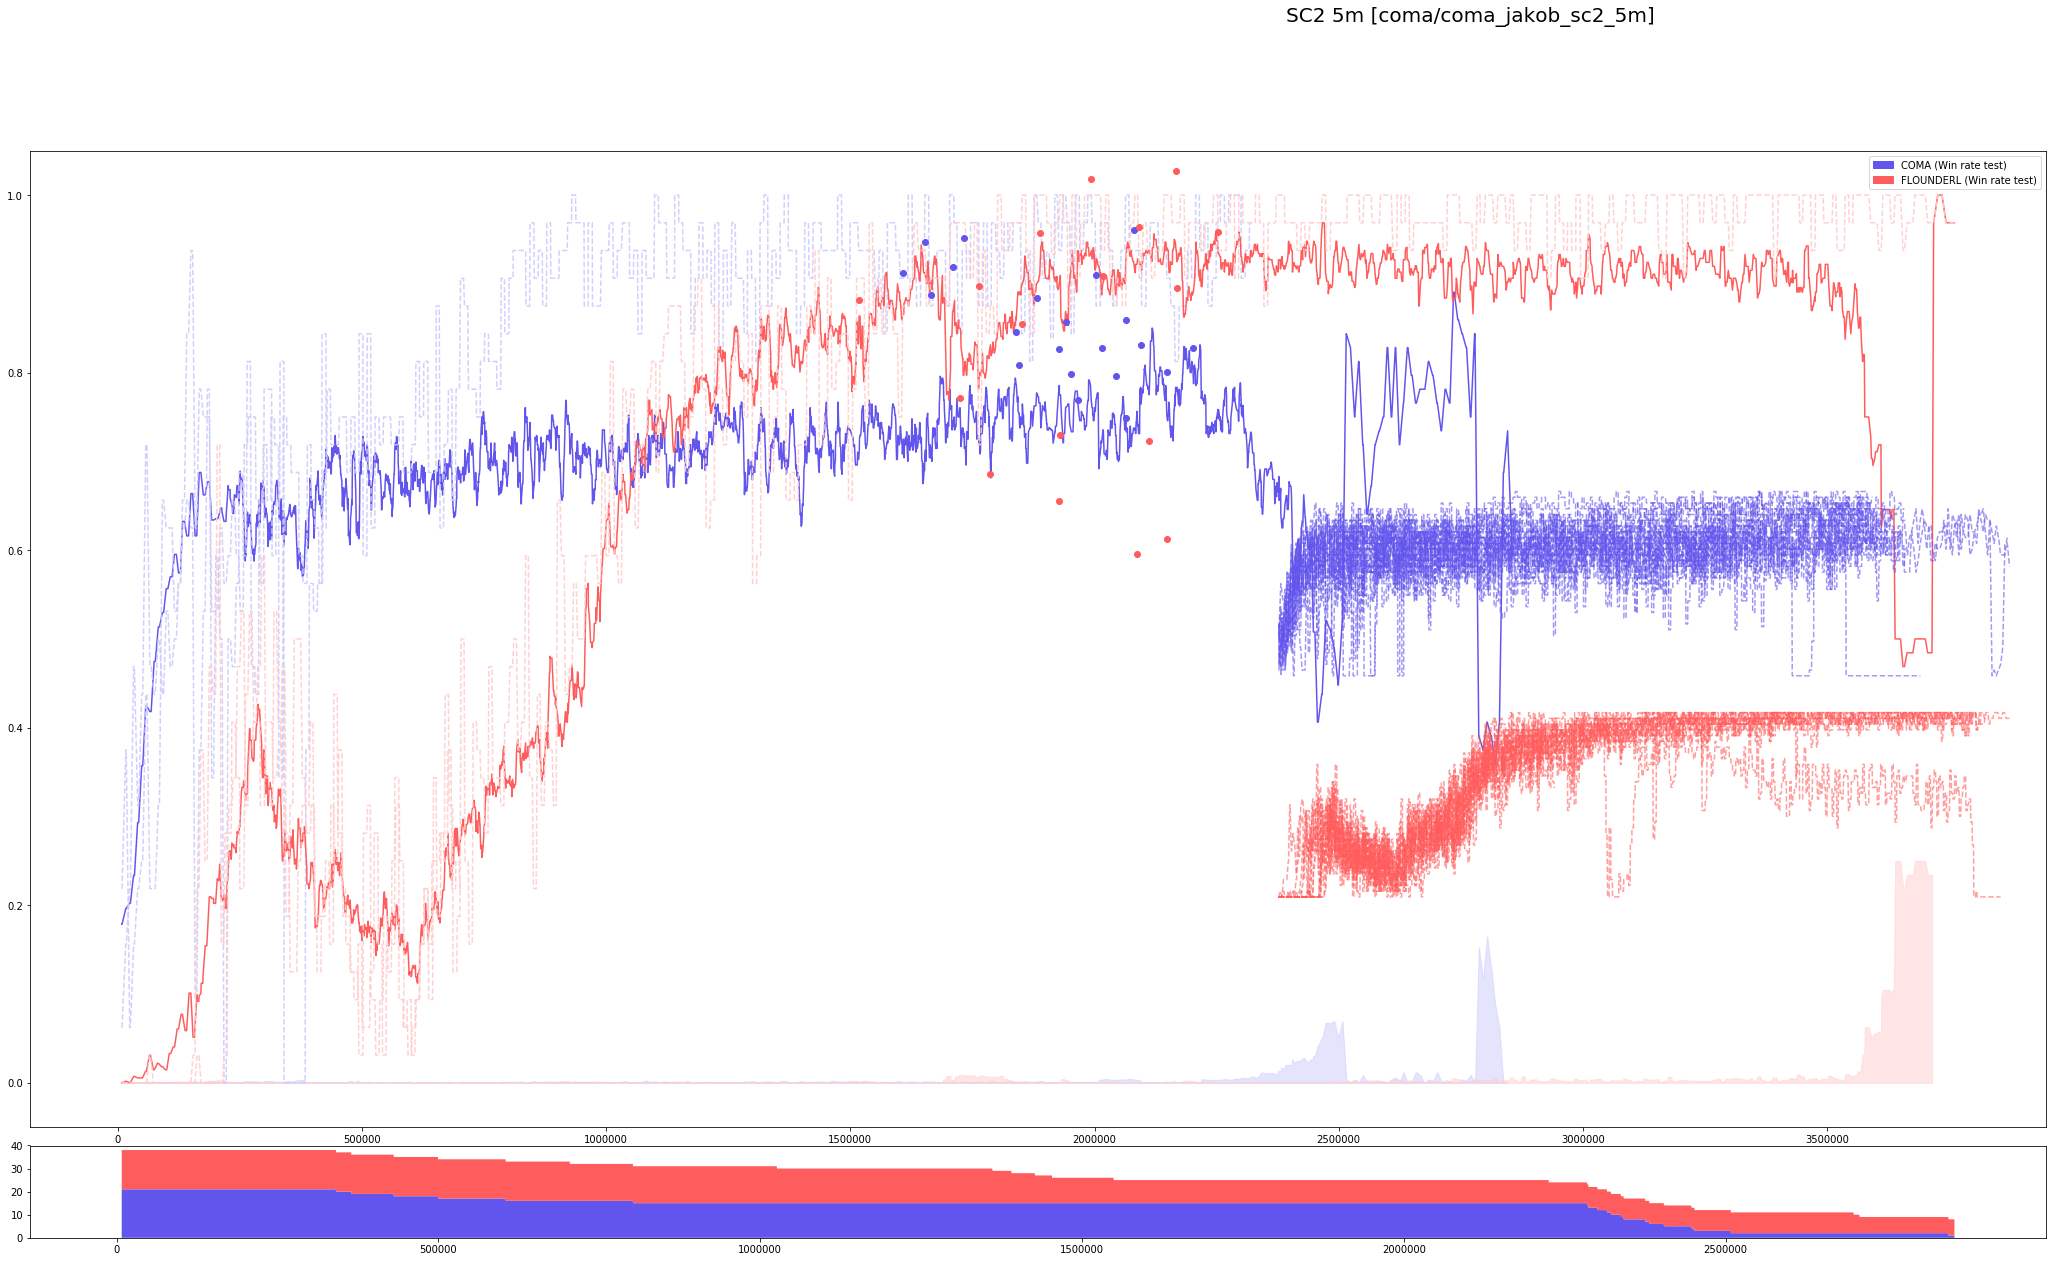

In [8]:
d4 = plot_bundles([cjak2, flok6_5m], 
                  mongo_central, 
                  ["Win rate test"]*2, 
                  labels=["COMA", "FLOUNDERL"],
                  x_range=None,
                 fig_title="SC2 5m")
#pprint.pprint(flok6_3m)
#pprint.pprint(flok6_5m)
#pprint.pprint(flok6_4a6x6pp)

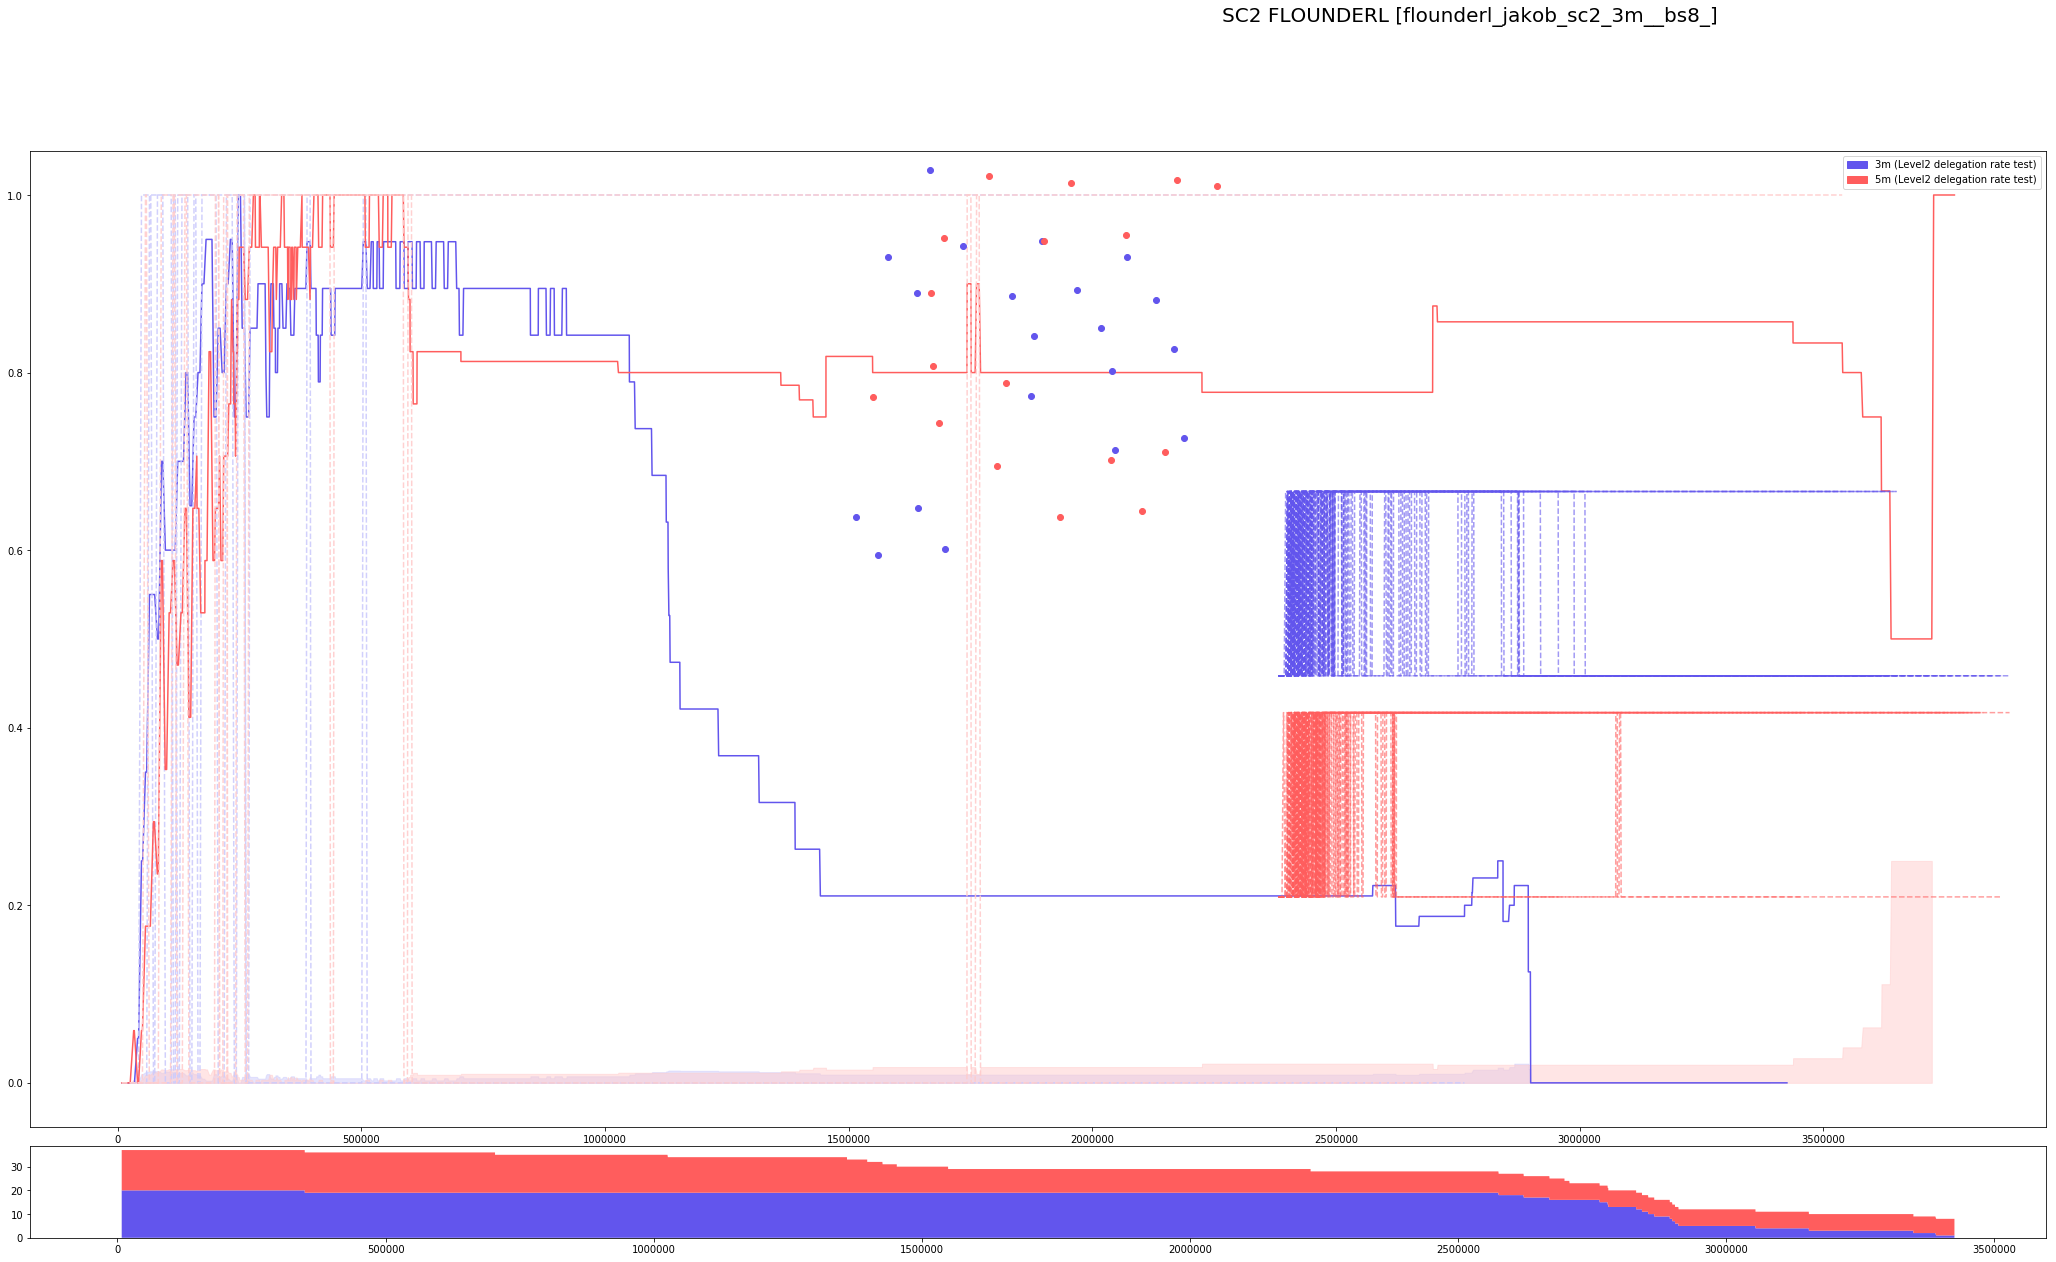

In [13]:
d4 = plot_bundles([flok6_3m, flok6_5m], 
                  mongo_central, 
                  ["Level2 delegation rate test"]*2, 
                  labels=["3m", "5m"],
                  x_range=None,
                 fig_title="SC2 FLOUNDERL")

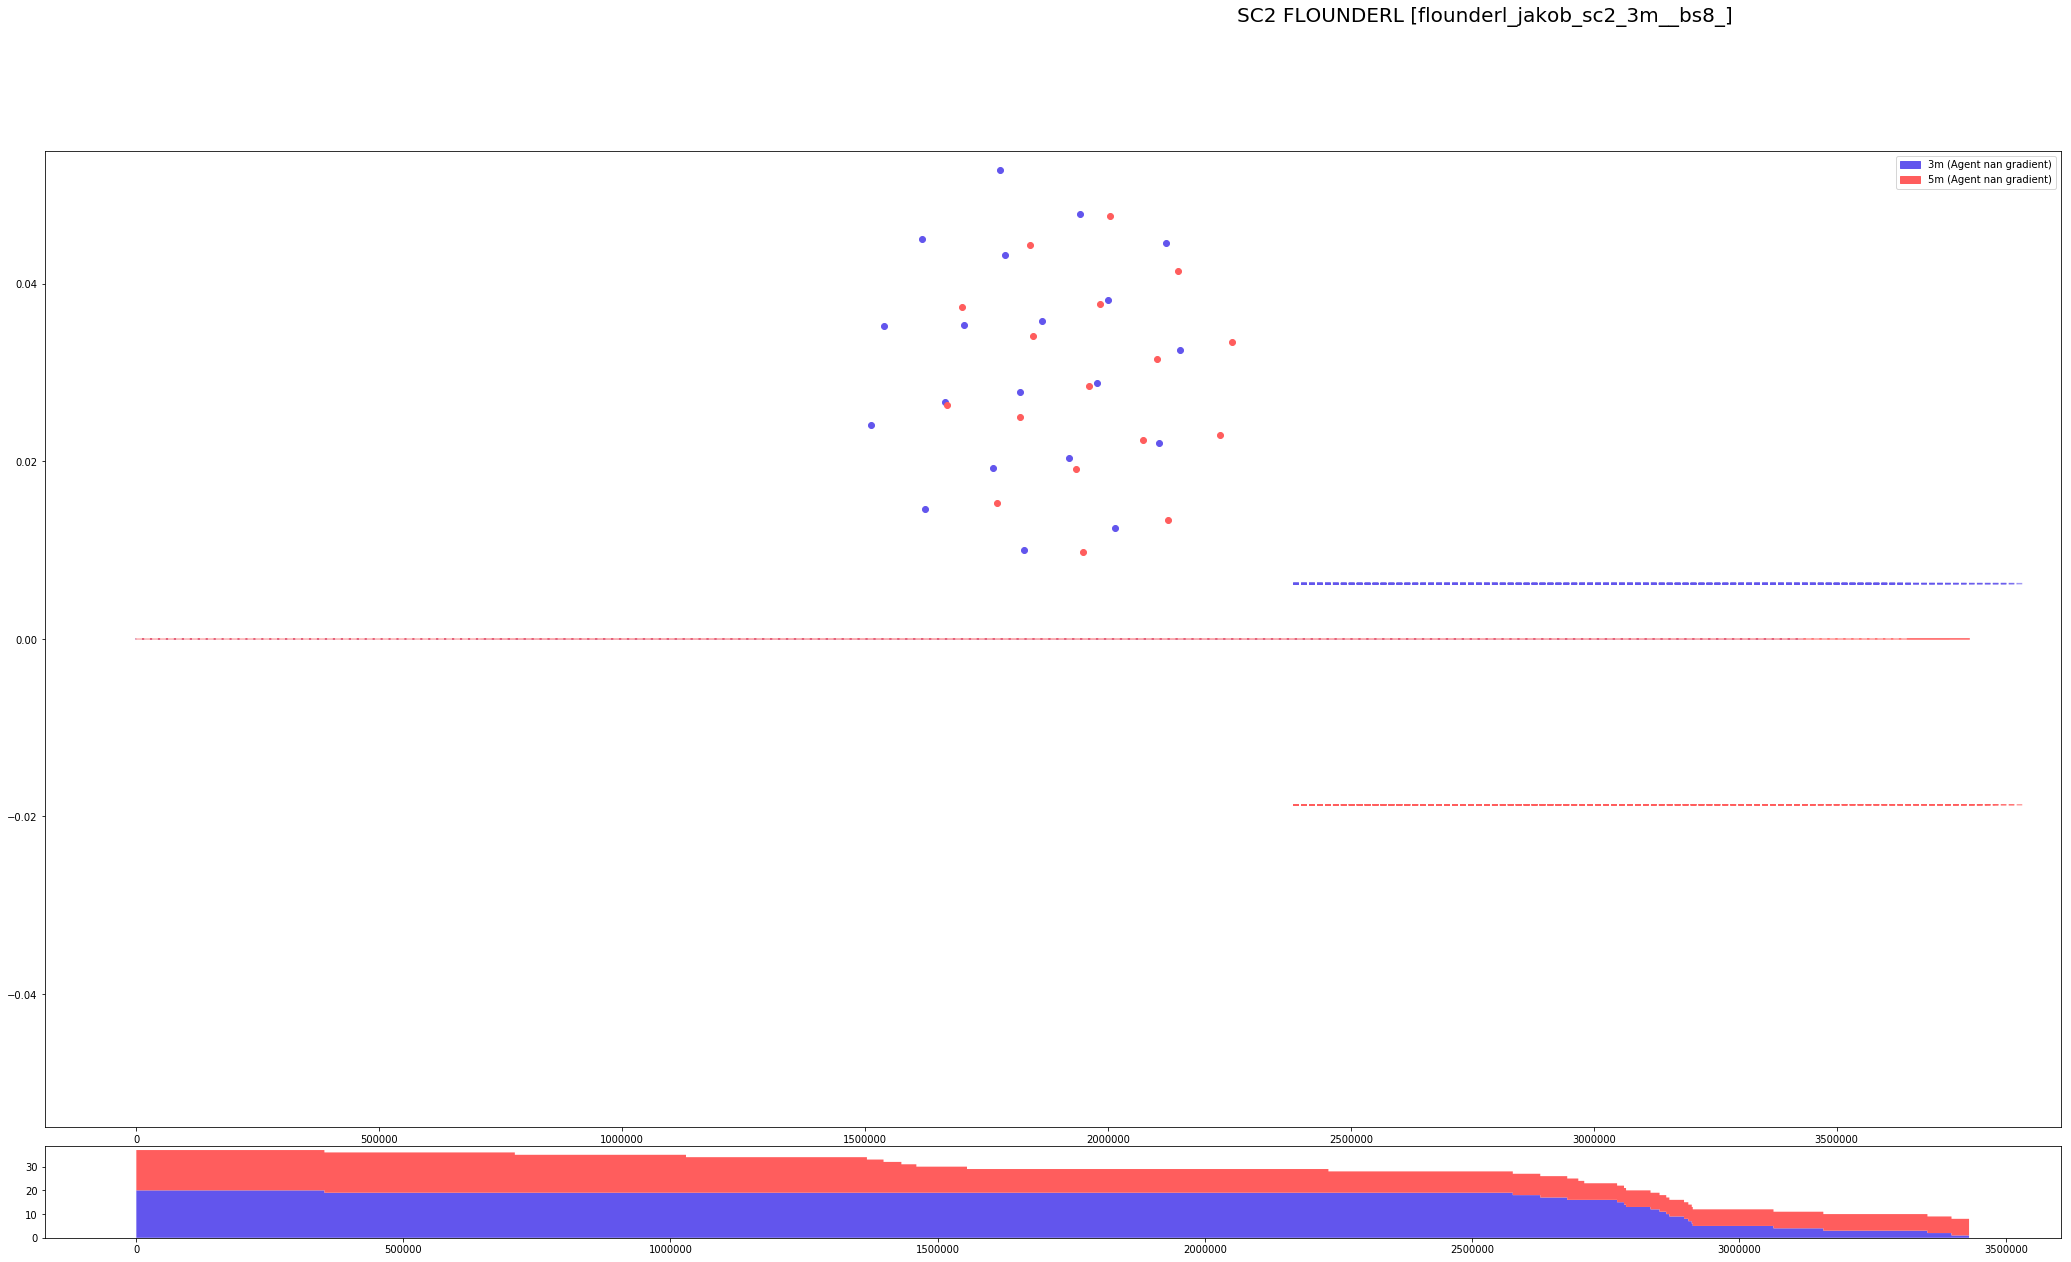

In [14]:
d4 = plot_bundles([flok6_3m, flok6_5m], 
                  mongo_central, 
                  ["Agent nan gradient"]*2, 
                  labels=["3m", "5m"],
                  x_range=None,
                 fig_title="SC2 FLOUNDERL")

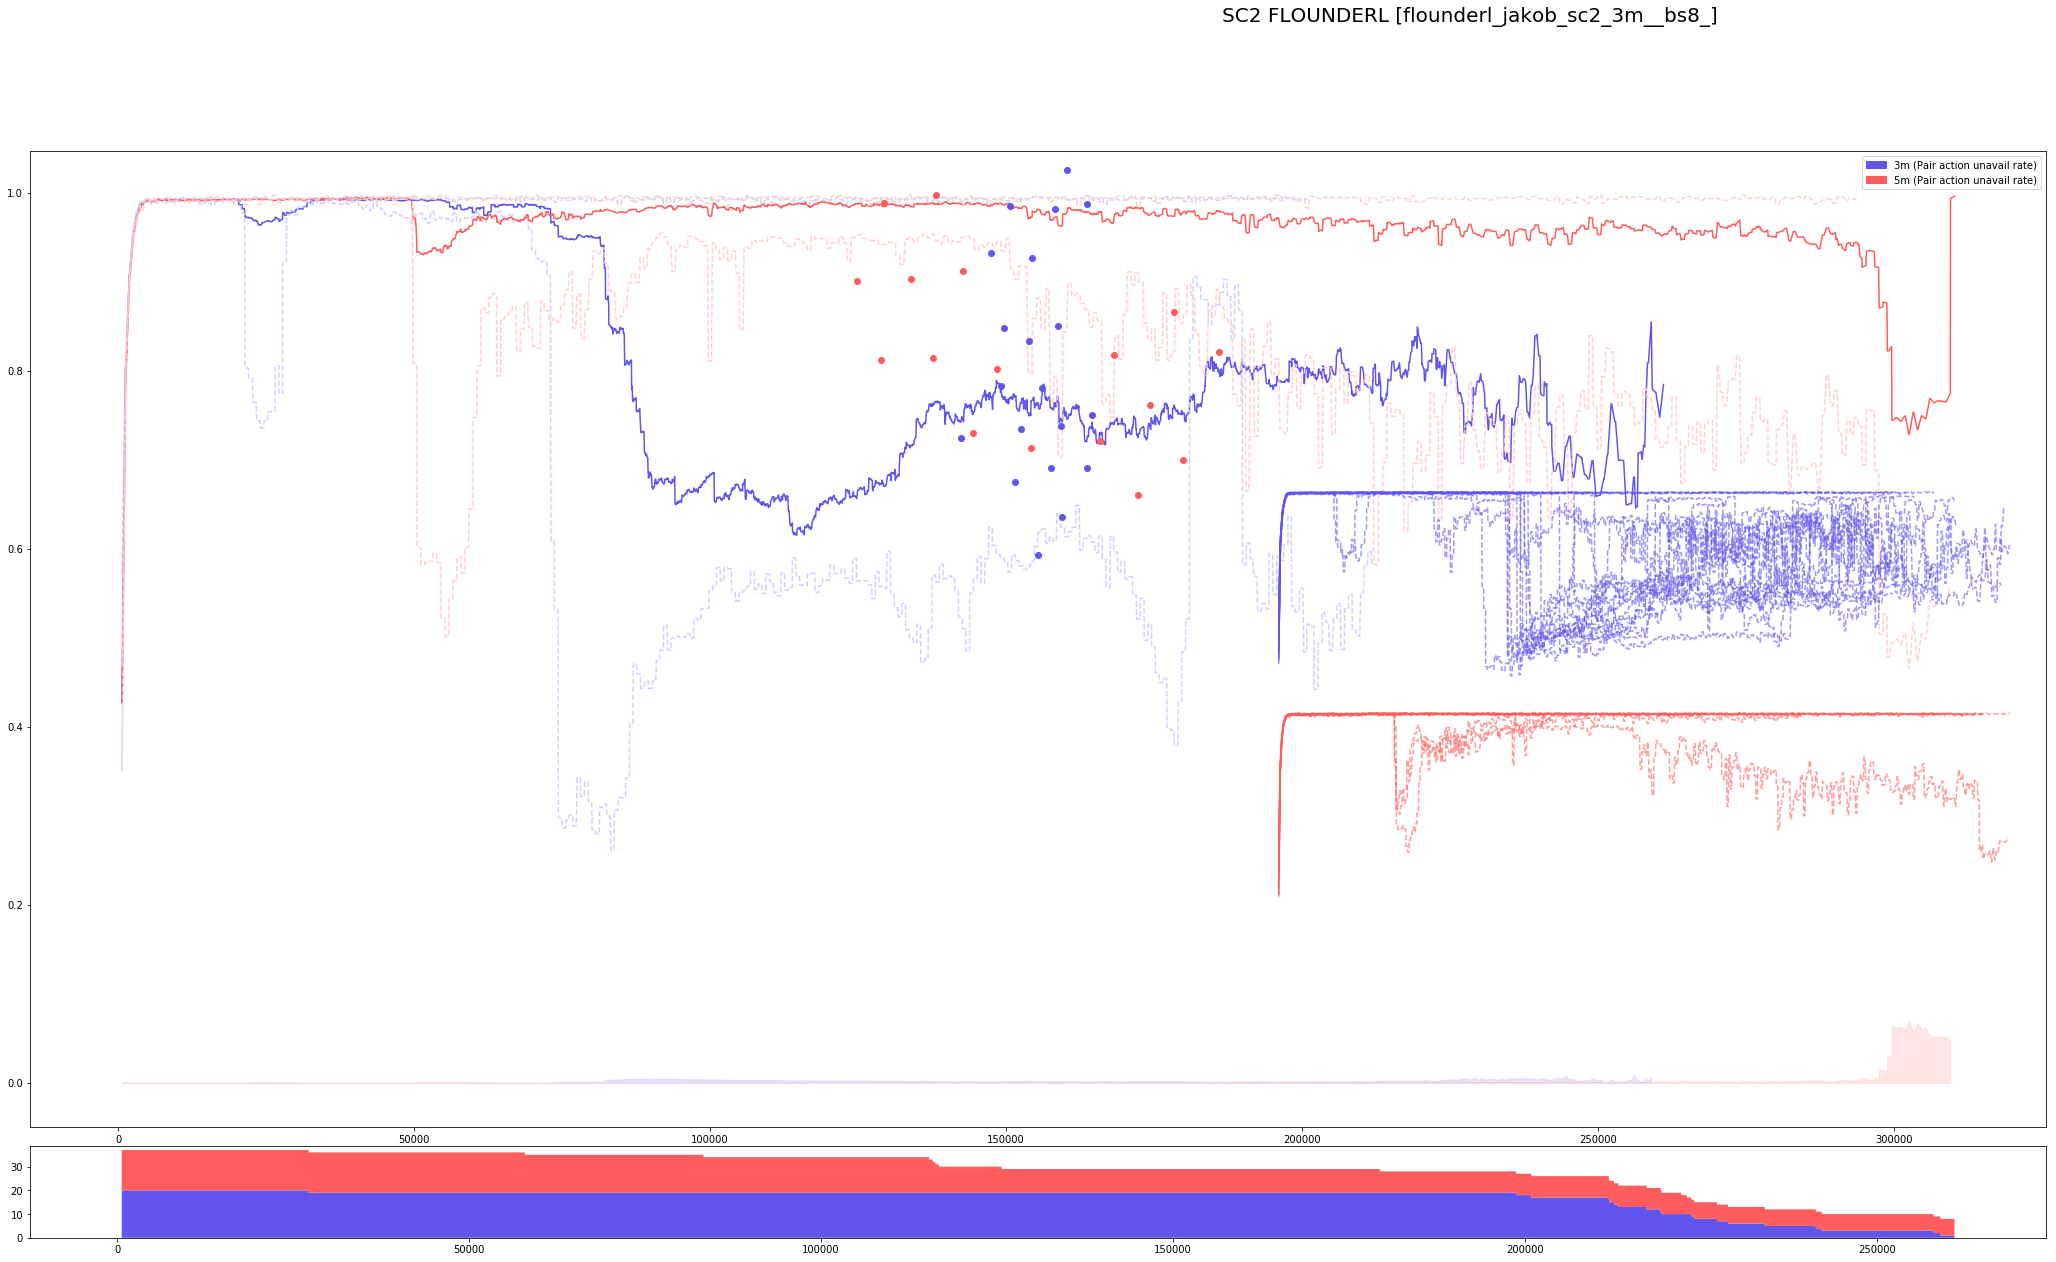

In [15]:
d4 = plot_bundles([flok6_3m, flok6_5m], 
                  mongo_central, 
                  ["Pair action unavail rate"]*2, 
                  labels=["3m", "5m"],
                  x_range=None,
                 fig_title="SC2 FLOUNDERL")

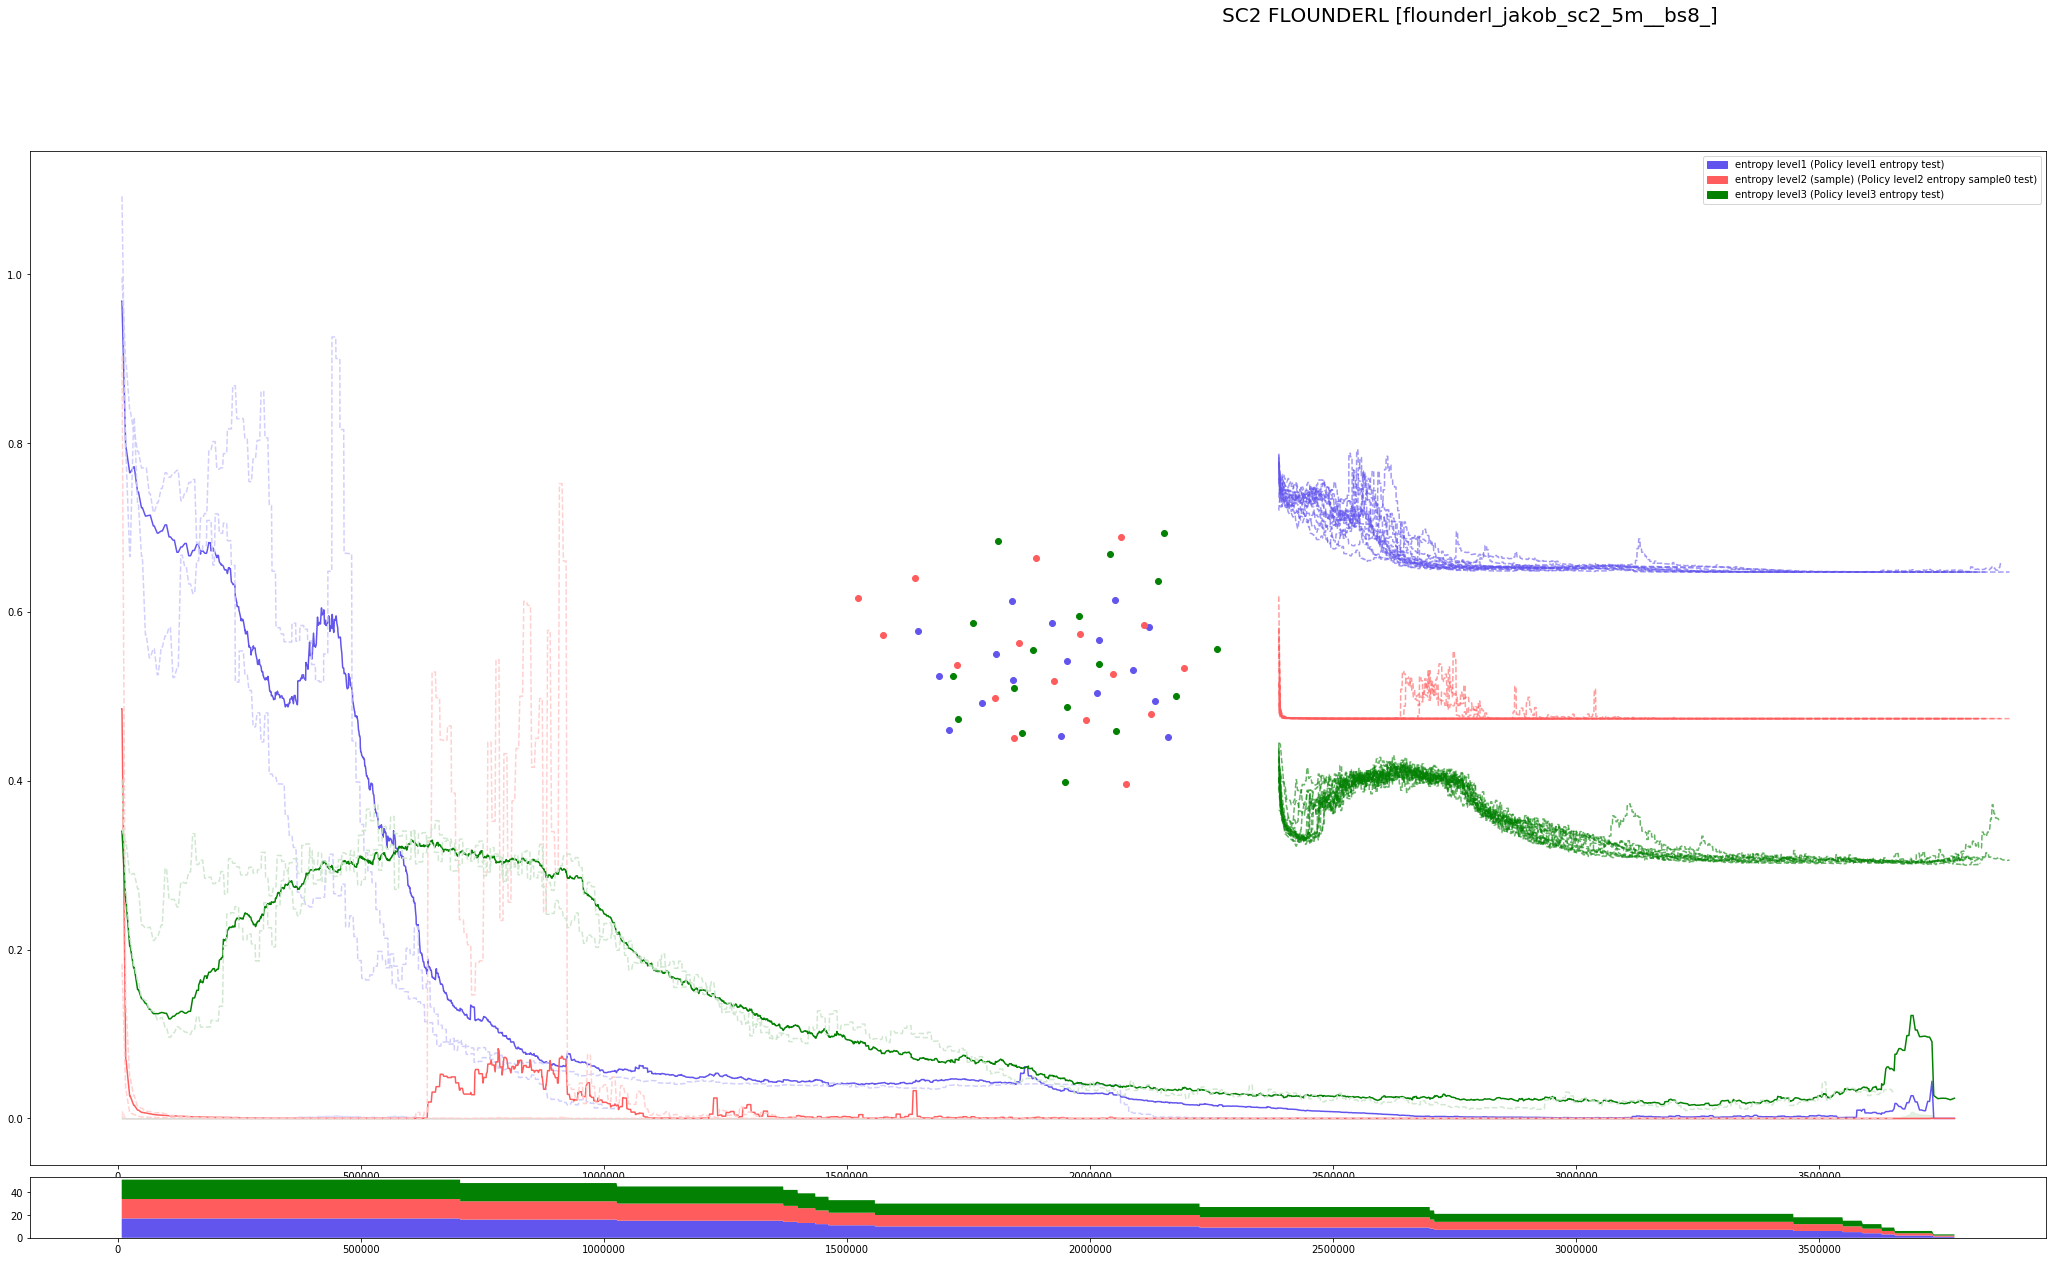

In [16]:
d4 = plot_bundles([flok6_5m, flok6_5m, flok6_5m], 
                  mongo_central, 
                  ["Policy level1 entropy test", "Policy level2 entropy sample0 test", "Policy level3 entropy test"], 
                  labels=["entropy level1", "entropy level2 (sample)", "entropy level3"],
                  x_range=None,
                 fig_title="SC2 FLOUNDERL")

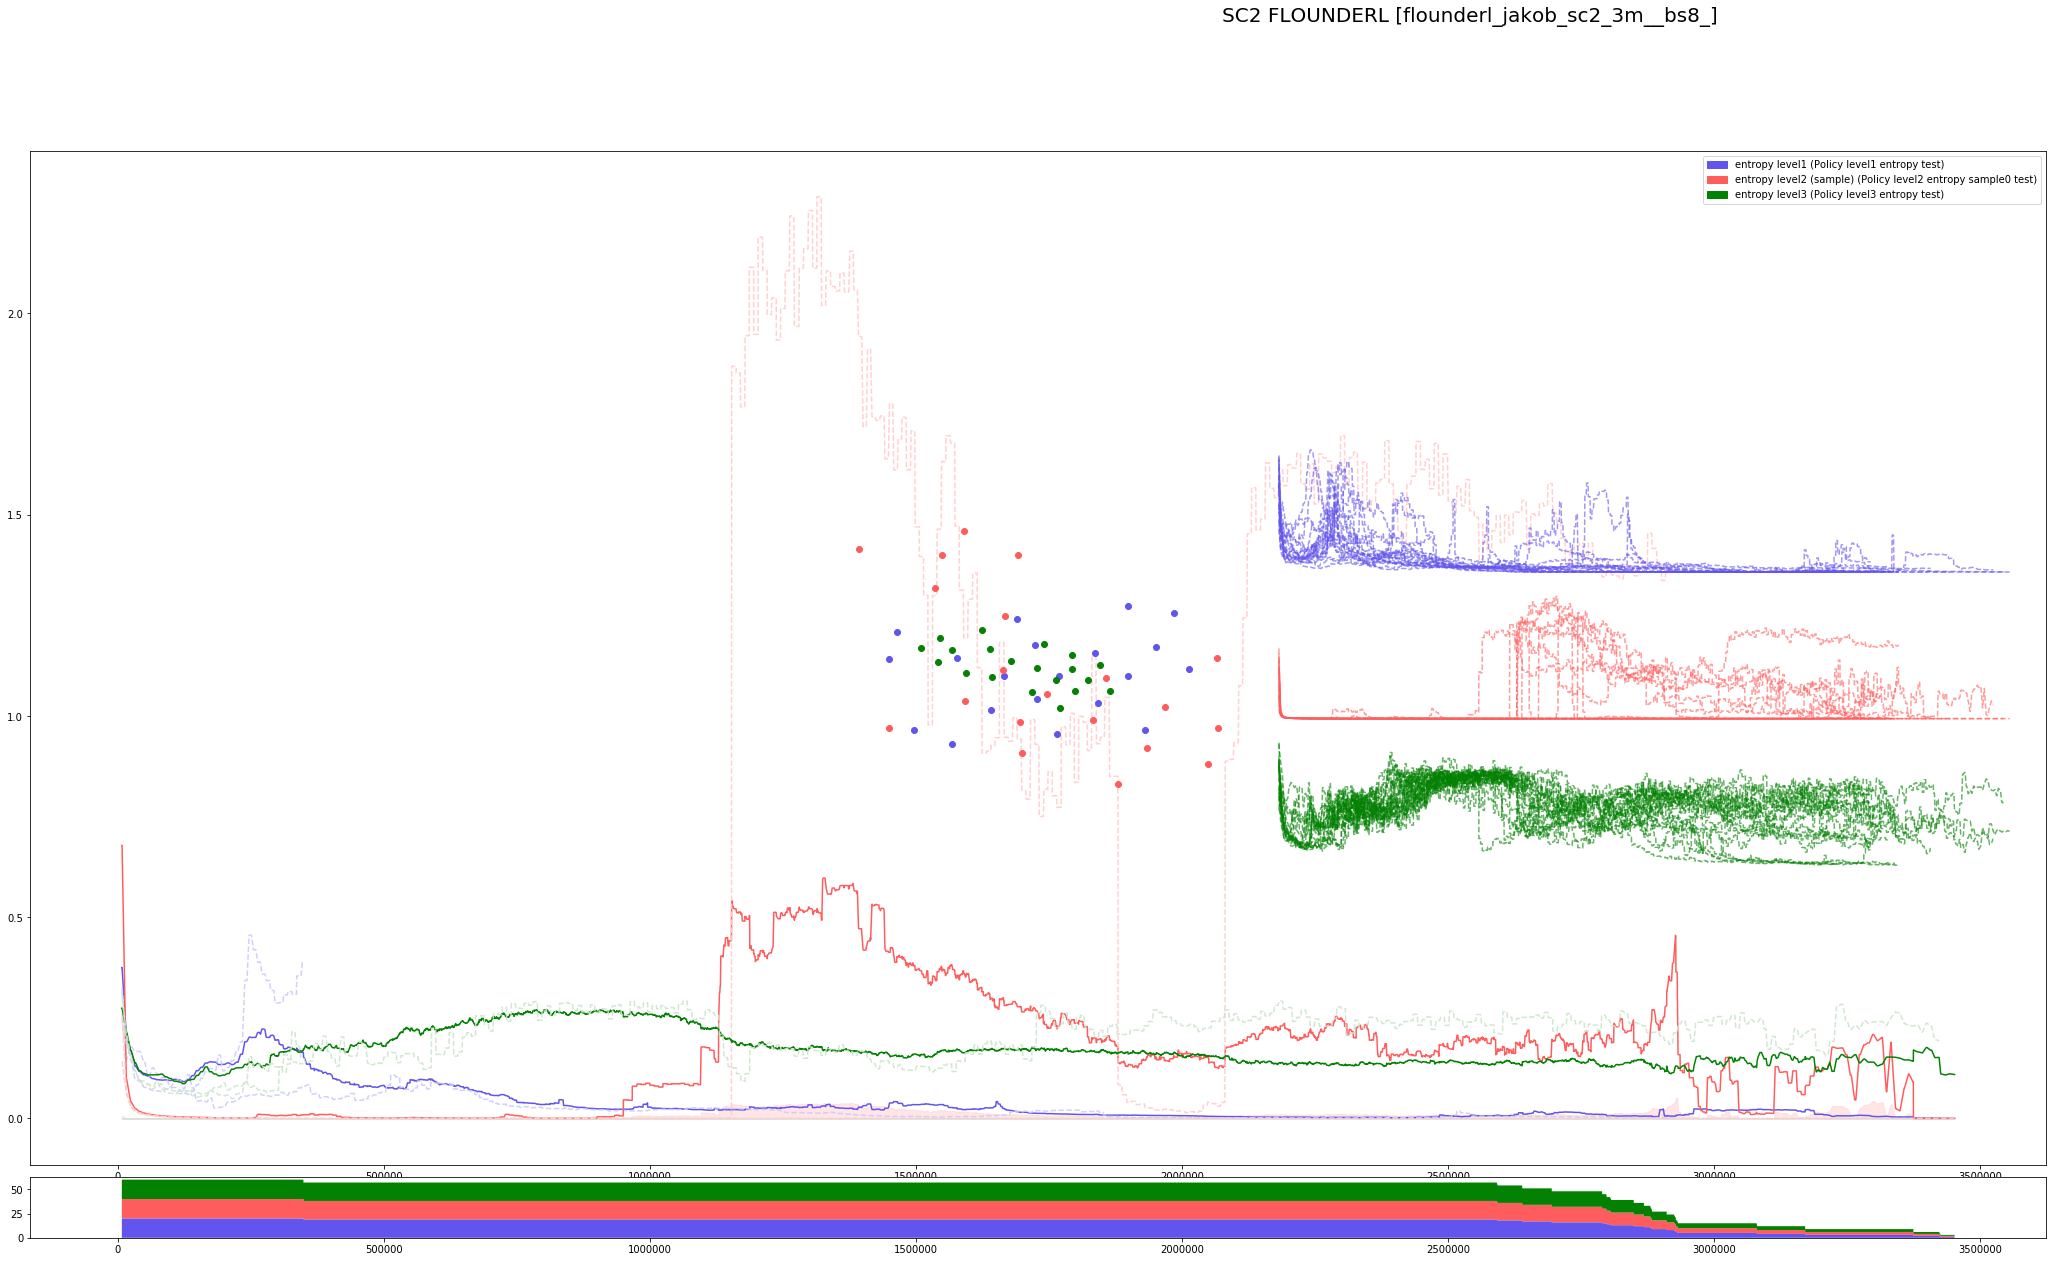

In [17]:
d4 = plot_bundles([flok6_3m, flok6_3m, flok6_3m], 
                  mongo_central, 
                  ["Policy level1 entropy test", "Policy level2 entropy sample0 test", "Policy level3 entropy test"], 
                  labels=["entropy level1", "entropy level2 (sample)", "entropy level3"],
                  x_range=None,
                 fig_title="SC2 FLOUNDERL")

In [ ]:
d4 = plot_bundles([comajakob, flok6_3m], 
                  mongo_central, 
                  ["Win rate test"]*2, 
                  labels=["COMA", "FLOUNDERL"],
                  x_range=None,
                 fig_title="SC2 5m")

In [ ]:
d4 = plot_bundles([coma_noexp, coma_100kexp, coma_200kexp], 
                  mongo_central, 
                  ["Episode reward test"]*3, 
                  labels=["noexp", "100k", "200k"],
                  x_range=(0, 1000000))

In [ ]:
d4 = plot_bundles([coma_noexp]*2, 
                  mongo_central, 
                  ["Episode reward test"]*1+["Episode reward"]*1, 
                  labels=["noexp"]*2,
                  x_range=(0, 1000000))

In [ ]:
d4 = plot_bundles([coma_noexp, coma_100kexp, coma_200kexp], 
                  mongo_central, 
                  ["Policy entropy"]*3, 
                  labels=["noexp", "100k", "200k"],
                  x_range=(0, 500000))

In [ ]:
flok5 = mongo_central.get_tag_names("FLOK2_5m")
flok3 = mongo_central.get_tag_names("FLOK2_3m")

pprint.pprint(flok5)
pprint.pprint(flok3)


In [ ]:
d4 = plot_bundles([flok5, flok3], 
                  mongo_central, 
                  ["Win rate test"]*2, 
                  labels=["5m", "3m"],
                  x_range=(0, 3000000))

In [ ]:
flok3_5 = mongo_central.get_tag_names("FLOK3_5m")
flok3_3 = mongo_central.get_tag_names("FLOK3_3m")

pprint.pprint(flok3_5)
pprint.pprint(flok3_3)


In [ ]:
d4 = plot_bundles([flok3_5, flok3_3], 
                  mongo_central, 
                  ["Win rate test"]*2, 
                  labels=["5m", "3m"],
                  x_range=(0, 3000000))

In [ ]:
d4 = plot_bundles([flok3_5, flok3_3], 
                  mongo_central, 
                  ["Agent nan gradient"]*2, 
                  labels=["5m", "3m"],
                  x_range=(0, 3000000))

In [ ]:
d4 = plot_bundles([flok3_5, flok3_3], 
                  mongo_central, 
                  ["Obs intersection all rate"]*2, 
                  labels=["5m", "3m"],
                  x_range=(0, 3000000))

In [ ]:
d4 = plot_bundles([flok3_5, flok3_3], 
                  mongo_central, 
                  ["Active pair intersections overlap test"]*2, 
                  labels=["5m", "3m"],
                  x_range=(0, 3000000))

In [ ]:
mc_coma_noexp_fo_6x6 = mongo_central.get_tag_names("MC_COMA_NOEXP_FO_6x6")
ms_coma_100kexp_fo_6x6 = mongo_central.get_tag_names("MC_COMA_100kEXP_FO_6x6")
mc_coma_noexp_6x6 = mongo_central.get_tag_names("MC_COMA_NOEXP_6x6")
ms_coma_100kexp_6x6 = mongo_central.get_tag_names("MC_COMA_100kEXP_6x6")

pprint.pprint(mc_coma_noexp_fo_6x6)
pprint.pprint(ms_coma_100kexp_fo_6x6)
pprint.pprint(mc_coma_noexp_6x6)
pprint.pprint(ms_coma_100kexp_6x6)

In [ ]:
d4 = plot_bundles([flok3_5, flok3_3], 
                  mongo_central, 
                  ["Obs overlap corr delegation test"]*2, 
                  labels=["5m", "3m"],
                  x_range=(0, 3000000))

In [ ]:
# d4 = plot_bundles([coma_noexp, coma_100kexp, mc_coma_noexp_fo, ms_coma_100kexp_fo], 
#                  mongo_central, 
#                  ["Episode reward"]*4, 
#                  labels=["noexp", "100k", "noexp_fo", "100k_fo"],
#                  x_range=(0, 1000000))
d4 = plot_bundles([mc_coma_noexp_fo_6x6, mc_coma_noexp_6x6], 
                   mongo_central, 
                   ["Episode reward test"]*2, 
                   labels=["noexp_fo", "noexp"],
                   x_range=(0, 1500000))

In [ ]:
d4 = plot_bundles([ms_coma_100kexp_fo_6x6, ms_coma_100kexp_6x6], 
                   mongo_central, 
                   ["Episode reward test"]*2, 
                   labels=["100kexp_fo", "100kexp"],
                   x_range=(0, 1500000))

In [ ]:
d4 = plot_bundles([coma_noexp, coma_100kexp, mc_coma_noexp_fo, ms_coma_100kexp_fo], 
                  mongo_central, 
                  ["Episode reward test"]*4, 
                  labels=["noexp", "100k", "noexp_fo", "100k_fo"],
                  x_range=(0, 1000000))

In [ ]:
import pprint
cjak2 = mongo_central.get_tag_names("CJAK2")

pprint.pprint(cjak2)

In [ ]:
d4 = plot_bundles([cjak2], 
                  mongo_central, 
                  ["Episode reward test"]*1, 
                  labels=["5m SC2"],
                  ) # x_range=(0, 2000000)

In [ ]:
d4 = plot_bundles([cjak2], 
                  mongo_central, 
                  ["Win rate test"]*1, 
                  labels=["5m SC2"],
                  ) # x_range=(0, 2000000)

/home/cs/Documents/pymarl/venv/pymarl/lib/python3.5/site-packages/ipykernel_launcher.py:52: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False


/home/cs/Documents/pymarl/venv/pymarl/lib/python3.5/site-packages/ipykernel_launcher.py:83: FutureWarning:

'.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.



AttributeError: 'NoneType' object has no attribute 'remove'

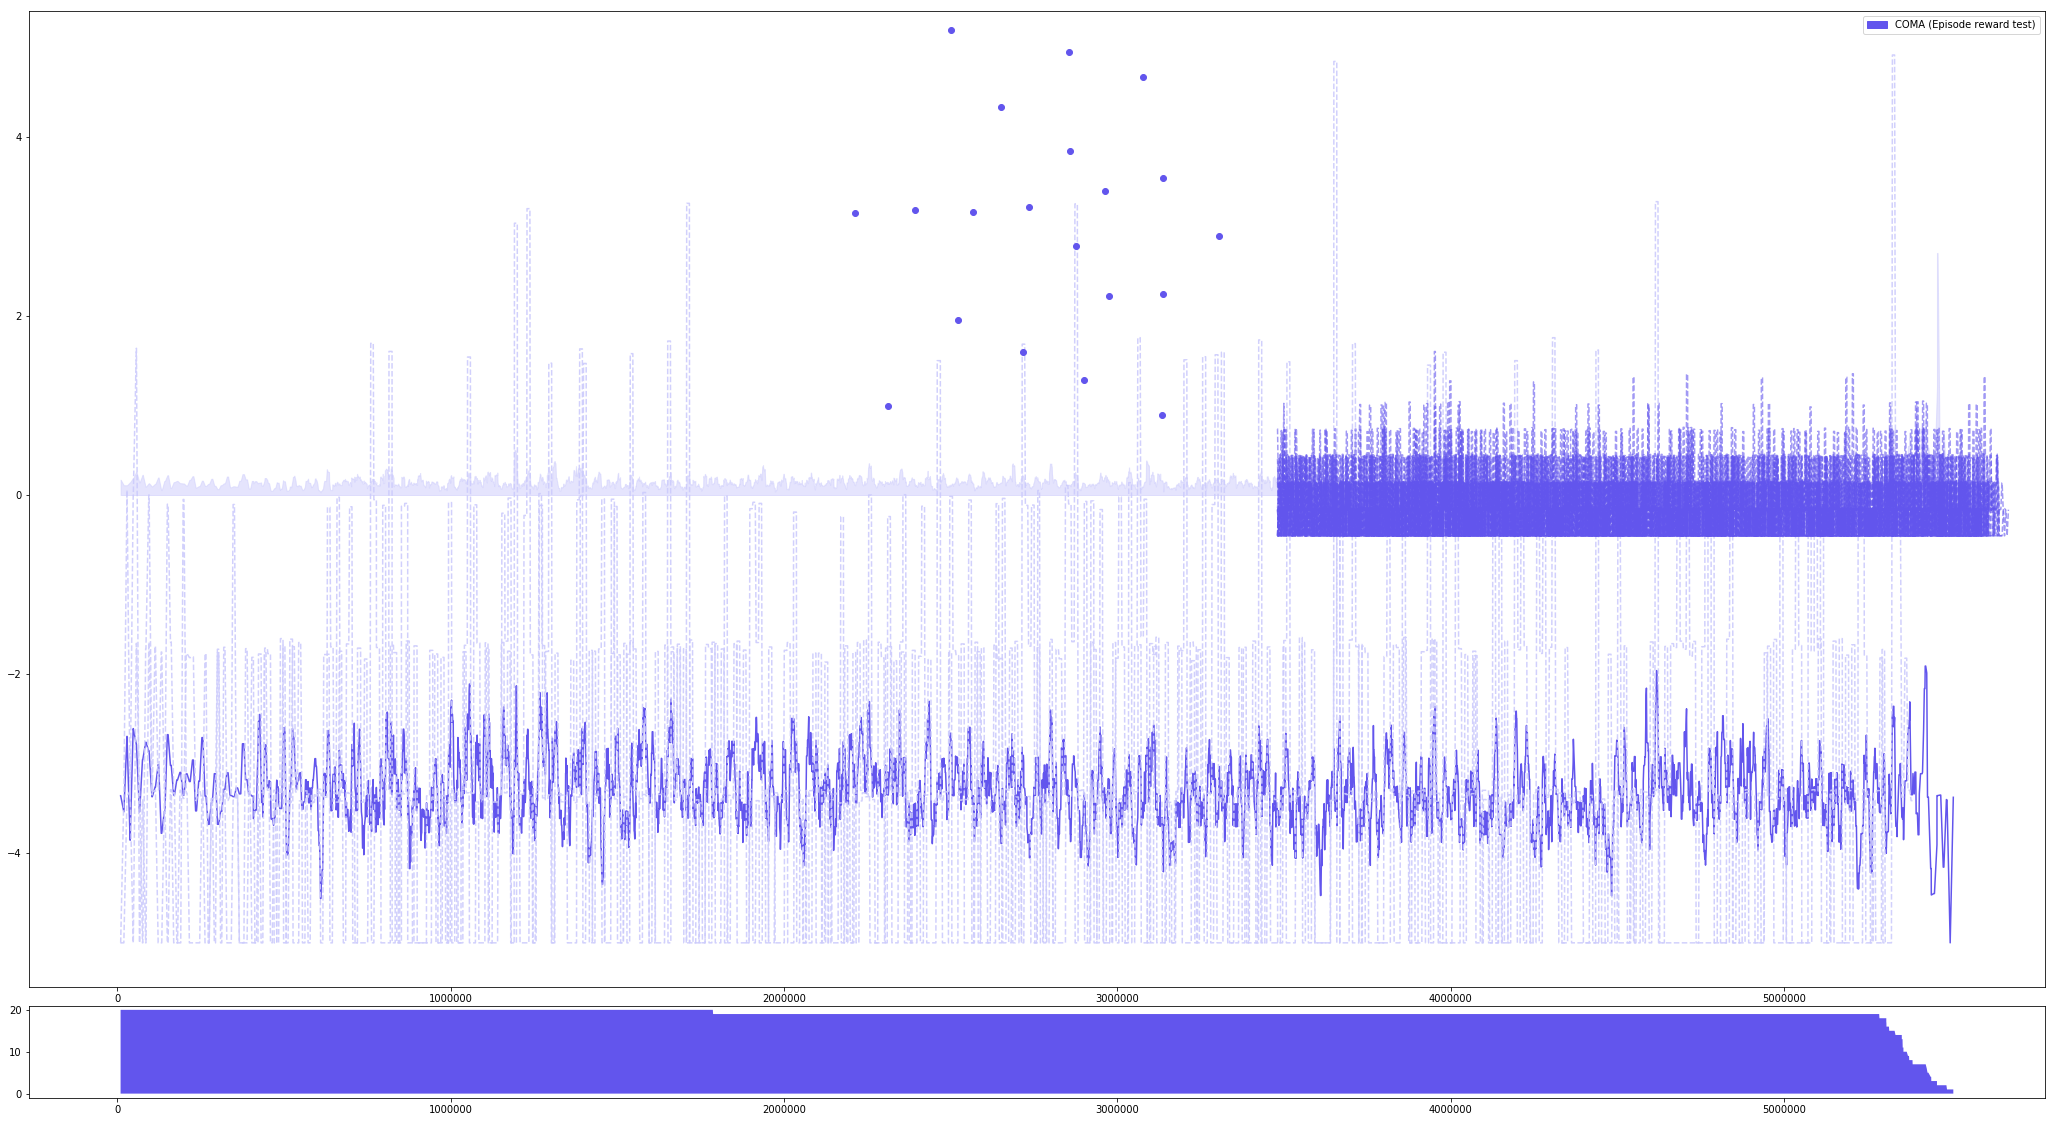

In [23]:
d4 = plot_bundles([flok6_4a6x6pp, cjak2], 
                  mongo_central, 
                  ["Episode reward test"], 
                  labels=["COMA"],
                  x_range=None,
                 fig_title="SC2 5m")

In [20]:
#d3 = plot_bundle(fo_mace5, mongo_central, prop="Critic loss", mode="individual")

In [ ]:
#d4 = plot_bundle(fo_coma, mongo_central, prop="Policy entropy", mode="individual")

In [ ]:
#d4 = plot_bundle(fo_coma, mongo_central, prop="Policy entropy test", mode="individual")

In [ ]:
#d7 = plot_bundle(fo_coma, mongo_central, prop="Episode length test", mode="individual")

In [ ]:
#d7 = plot_bundle(fo_mace5, mongo_central, prop="Episode length test", mode="individual")

In [ ]:
#d1 = plot_bundle(fo_mace5, mongo_central, prop="Policy entropy", mode="individual")

In [ ]:
#d1 = plot_bundle(fo_mace5, mongo_central, prop="Policy entropy test", mode="individual")

In [ ]:
#d1 = plot_bundle(fo_coma, mongo_central, prop="Policy entropy test", mode="individual")

In [ ]:
#d1 = plot_bundle(fo_mace5, mongo_central, prop="Sigma norm", mode="individual")

In [ ]:
#d1 = plot_bundle(fo_mace5, mongo_central, prop="Sigma entropy", mode="individual")

In [ ]:
#d1 = plot_bundle(fo_mace5, mongo_central, prop="Sigma entropy test", mode="individual")

In [ ]:
#d1 = plot_bundle(fo_mace5, mongo_central, prop="Sigma grad norm", mode="individual")